## What is an Agent?

**Agent의 정의**:
- LLM + Tools + Memory + Reasoning Loop
- 사용자 요청을 해결하기 위해 **도구를 사용**하고 **여러 단계를 거쳐** 문제를 해결하는 시스템

**Agent의 핵심 구성 요소**:

1. **LLM (Large Language Model)**: 추론 엔진
2. **Tools**: 외부 시스템과 상호작용 (검색, 계산, API 호출 등)
3. **Memory**: 대화 기록 및 컨텍스트 유지
4. **Reasoning Loop**:
   - Think: 다음 행동 결정
   - Act: 도구 호출 또는 답변 생성
   - Observe: 도구 결과 확인
   - Repeat: 목표 달성까지 반복

**ReAct Pattern** (Reasoning + Acting):
```
[User Query] → Think (LLM) → Act (Tool Call) → Observe (Tool Result) → Think (LLM) → ...
```

**Single Agent Use Cases**:
- 단순한 질의응답 (QA)
- 단일 도구만 필요한 작업 (검색, 계산)
- 빠른 응답이 중요한 경우 (고객 상담 초기 대응)

## Workflows

### Workflows vs Agents

Workflows와 Agents는 모두 LLM을 활용한 시스템이나 `제어 방식`과 `실행 경로`가 다릅니다.

Workflows:
- 미리 정해진 경로: 개발자가 명시적으로 정의한 단계와 분기를 따라 실행
- 결정적(Deterministic) 로직: 같은 입력 → 같은 경로 → 예측 가능한 결과
- 조건부 분기: 룰 기반 또는 간단한 분류기로 경로 결정
- 도구 사용: 특정 단계에서 고정된 도구 호출 (선택적)

Agents:
- 동적인 경로: LLM이 매 단계마다 다음 행동을 결정 (도구 호출 or 답변)
- 비결정적: 같은 입력이라도 실행마다 다른 경로를 탈 수 있음
- ReAct 루프: Think → Act → Observe 반복, 목표 달성까지 자율 진행
- 도구 생태: 여러 도구 중 상황에 맞는 것을 LLM이 선택

### 비교표

| 기준          | Workflows                          | Agents                               |
|-------------------|----------------------------------------|------------------------------------------|
| 제어 방식     | 명시적 그래프 구조 (개발자 정의)      | LLM 기반 자율 의사결정                   |
| 경로 결정     | 컴파일 타임 or 간단한 룰 기반          | 런타임에 LLM이 동적으로 결정              |
| 도구 사용     | 고정된 단계에서 특정 도구 호출         | 필요 시 LLM이 도구 선택 및 호출           |
| 디버깅        | 그래프 시각화로 명확, 단계별 추적 용이 | 블랙박스적 특성, 로그 분석 필요           |
| 반복 구조     | 조건부 루프 (최대 횟수 명시)           | ReAct 루프 (중단 조건 or 최대 스텝)      |
| 주 사용처     | 검증 가능한 파이프라인, 품질 보장 우선 | 탐색적 작업, 복잡한 도구 조합 필요 시     |

### 언제 무엇을 선택할까요?

Workflows:
- 단계가 명확하고 검증 가능한 작업 (예: 문서 번역 → 검토 → 최종 편집)
- 비용/속도 최적화가 중요 (불필요한 LLM 호출 최소화)
- 디버깅과 테스트 용이성 우선
- 규제/컴플라이언스 요구사항 (실행 경로 감사 가능)

Agents:
- 문제 해결 방법이 사전에 정의 불가 (예: 오픈엔드 리서치)
- 도구 선택/순서가 입력에 따라 크게 변함
- 탐색과 시행착오가 필요한 작업
- 품질 > 비용 (여러 시도를 통해 최선의 결과 도출)


In [1]:
import ast
import operator
from dataclasses import dataclass
from pprint import pprint
from typing import Annotated, Literal, TypedDict

from dotenv import load_dotenv
from langchain.agents import create_agent
from langchain.messages import AIMessage, AnyMessage, HumanMessage, SystemMessage
from langchain.tools import ToolRuntime, tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_tavily import TavilySearch
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.runtime import Runtime
from pydantic import BaseModel, Field

load_dotenv()

from openrouter_llm import (
    create_embedding_model,
    create_embedding_model_direct,
    create_openrouter_llm,
)

# LLM 선언
llm = create_openrouter_llm("openai/gpt-4.1-mini")
openai_embeddings = create_embedding_model("openai/text-embedding-3-small")
qwen_embeddings = create_embedding_model_direct("qwen/qwen3-embedding-0.6b")

## 예제로 설명하는 AI Agent: IT 헬프데스크 

IT 헬프데스크를 위한 5개 도구를 정의합니다.  
`from langchain.tools import tool` 의 `@tool` 데코레이터를 사용합니다.

**도구 목록**:
1. `reset_password`: 비밀번호 초기화
2. `check_account_status`: 계정 상태 확인
3. `search_knowledge_base`: KB 기술문서 검색
4. `check_ticket_status`: 티켓 조회
5. `create_ticket`: 새 티켓 생성

In [ ]:
# JSON 데이터 로드 헬퍼 함수
import json
from pathlib import Path


def load_kb_articles():
    """기술문서 JSON 파일 로드"""
    kb_path = Path("data/kb_articles.json")
    if kb_path.exists():
        with open(kb_path, encoding="utf-8") as f:
            return json.load(f)
    return []


def load_sample_tickets():
    """티켓 JSON 파일 로드"""
    tickets_path = Path("data/sample_tickets.json")
    if tickets_path.exists():
        with open(tickets_path, encoding="utf-8") as f:
            return json.load(f)
    return []

In [4]:
# IT 헬프데스크 도구 정의 (5개)
@tool
async def reset_password(user_id: str) -> str:
    """비밀번호 초기화 및 임시 비밀번호 이메일 발송 (Mock)

    Args:
        user_id: 사용자 ID (예: "user-alice-001")

    Returns:
        비밀번호 초기화 결과 메시지
    """
    email = f"{user_id.split('-')[1]}@company.com"
    temp_password = f"Temp{user_id[-3:]}!"
    return f"비밀번호가 초기화되었습니다. 임시 비밀번호({temp_password})를 {email}으로 발송했습니다. 로그인 후 즉시 변경하세요."


@tool
async def check_account_status(user_id: str) -> str:
    """계정 상태 확인 (Mock)

    Args:
        user_id: 사용자 ID (예: "user-bob-001")

    Returns:
        계정 상태 정보 (활성/잠김/만료)

    Example:
        >>> check_account_status("user-bob-001")
        "계정 상태: 잠김 (로그인 5회 실패). IT 헬프데스크에 연락하여 계정을 해제하세요."
    """
    # Mock 구현: 간단한 룰 기반
    account_states = {
        "user-alice-001": "활성",
        "user-bob-001": "잠김 (로그인 5회 실패)",
        "user-charlie-001": "만료됨 (90일 미사용)",
    }
    status = account_states.get(user_id, "활성")

    if "잠김" in status:
        return f"계정 상태: {status}. IT 헬프데스크에 연락하여 계정을 해제하세요."
    elif "만료" in status:
        return f"계정 상태: {status}. 계정 재활성화를 요청하세요."
    else:
        return f"계정 상태: {status}. 정상적으로 사용 가능합니다."


@tool
async def search_knowledge_base(query: str) -> str:
    """내부 기술문서(KB) 검색 (data/kb_articles.json 사용)

    Args:
        query: 검색 키워드 (예: "VPN", "프린터")

    Returns:
        관련 KB 문서 정보

    Example:
        >>> search_knowledge_base("VPN")
        "[KB-001] VPN 연결 설정 가이드\\n내용: VPN 클라이언트 다운로드 및 설정 방법..."
    """
    kb_articles = load_kb_articles()
    if not kb_articles:
        return "⚠️ 기술문서를 찾을 수 없습니다. data/kb_articles.json 파일을 확인하세요."

    # 간단한 키워드 매칭 (실제 환경에서는 Vector Search 사용)
    results = []
    for article in kb_articles:
        if (
            query.lower() in article.get("title", "").lower()
            or query.lower() in article.get("content", "").lower()
        ):
            results.append(
                f"[{article['article_id']}] {article['title']}\n내용: {article['content'][:100]}..."
            )

    if results:
        return "\n\n".join(results)
    else:
        return (
            f"'{query}'에 대한 기술문서를 찾을 수 없습니다. IT 헬프데스크(ext. 1234)에 문의하세요."
        )


@tool
async def check_ticket_status(ticket_id: str) -> str:
    """티켓 상태 조회 (sample_tickets.json 사용)

    Args:
        ticket_id: 티켓 ID (예: "TKT-2025-001")

    Returns:
        티켓 상태 정보
    """
    tickets = load_sample_tickets()
    if not tickets:
        return "⚠️ 티켓 데이터를 찾을 수 없습니다. data/sample_tickets.json 파일을 확인하세요."

    for ticket in tickets:
        if ticket["ticket_id"] == ticket_id:
            status_msg = f"[{ticket['ticket_id']}] {ticket['subject']}\n"
            status_msg += f"상태: {ticket['status']} | 우선순위: {ticket['priority']}\n"
            status_msg += f"담당자: {ticket.get('assigned_to', '미할당')} | 생성일: {ticket.get('created_at', 'N/A')}"
            return status_msg
    return f"티켓 {ticket_id}를 찾을 수 없습니다."


@tool
async def create_ticket(description: str, category: str = "general") -> str:
    """새 IT 티켓 생성 (Mock)

    Args:
        description: 티켓 설명 (예: "VPN 연결 실패")
        category: 티켓 카테고리 (기본값: "general")
                 선택 가능: account, network, software, hardware, general

    Returns:
        생성된 티켓 정보

    Example:
        >>> create_ticket("VPN 연결 실패", "network")
        "티켓 TKT-2025-011이 생성되었습니다. 카테고리: network | 우선순위: medium | IT 팀에서 확인 중입니다."
    """
    # Mock 구현 (실제 환경에서는 JIRA API 등 적절한 API 호출)
    import random

    ticket_id = f"TKT-2025-{random.randint(100, 999)}"
    priority = "medium"

    # 키워드 기반 우선순위 자동 결정
    urgent_keywords = ["긴급", "급함", "로그인 안 됨", "서버 다운"]
    if any(keyword in description for keyword in urgent_keywords):
        priority = "high"

    return f"티켓 {ticket_id}이 생성되었습니다. 카테고리: {category} | 우선순위: {priority} | IT 팀에서 확인 중입니다. 평균 응답 시간: 1-2시간"


# Tool 목록
tools = [
    reset_password,
    check_account_status,
    search_knowledge_base,
    check_ticket_status,
    create_ticket,
]

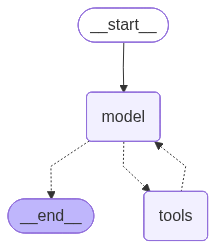

In [6]:
helpdesk_agent = create_agent(
    model=llm,
    tools=tools,
    debug=True,
)
helpdesk_agent

## Test: IT Helpdesk Agent 실행 예제

생성한 IT Helpdesk Agent를 다양한 시나리오로 테스트합니다.

**테스트 시나리오**:
1. 비밀번호 초기화 (단일 도구 호출)
2. VPN 연결 문의 (KB 검색)
3. 로그인 문제 (복합 작업: 계정 확인 + 비밀번호 초기화)

In [8]:
# Agent 실행 예제 1: 비밀번호 초기화
import nest_asyncio

nest_asyncio.apply()

response_1 = await helpdesk_agent.ainvoke(
    {
        "messages": [
            HumanMessage(content="비밀번호를 잊어버렸어요. 사용자 ID는 user-alice-001입니다.")
        ]
    }
)

# 메시지 히스토리 출력
print("\n[메시지 흐름]:")
for i, msg in enumerate(response_1["messages"], 1):
    msg_class = msg.__class__.__name__
    msg_name = getattr(msg, "name", "N/A")
    content_preview = str(msg.content)[:150]
    print(f"{i}. [{msg_class}] {msg_name}: {content_preview}...")

# 최종 답변 출력
final_answer_1 = response_1["messages"][-1].content
final_answer_1

[values] {'messages': [HumanMessage(content='비밀번호를 잊어버렸어요. 사용자 ID는 user-alice-001입니다.', additional_kwargs={}, response_metadata={}, id='993de833-62a5-495f-ab93-811176104666')]}
[updates] {'model': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 479, 'total_tokens': 499, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'openai/gpt-4.1-mini', 'system_fingerprint': None, 'id': 'gen-1762862342-Kp6x1BiWbocZad9iKwUz', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--baf4a016-960f-4f15-9612-8ee6cbd21f11-0', tool_calls=[{'name': 'reset_password', 'args': {'user_id': 'user-alice-001'}, 'id': 'call_NGdqrRtF1CugIPNt1xlKnRSf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 479, 'output_tokens': 20, 'total_t

'비밀번호가 초기화되었고, 임시 비밀번호가 alice@company.com으로 발송되었습니다. 로그인 후에는 임시 비밀번호를 즉시 변경하시기 바랍니다. 추가로 도움이 필요하시면 알려주세요.'

In [10]:
# Agent 실행 예제 2: VPN 연결 문의
import nest_asyncio

nest_asyncio.apply()

response_2 = await helpdesk_agent.ainvoke(
    {"messages": [HumanMessage(content="VPN 연결이 안 돼요. 어떻게 해야 하나요?")]}
)

# 최종 답변 출력
final_answer_2 = response_2["messages"][-1].content
print(f"ANSWER 2:{final_answer_2}")

# Agent 실행 예제 3: 복합 작업 (계정 확인 + 초기화)
response_3 = await helpdesk_agent.ainvoke(
    {"messages": [HumanMessage(content="로그인이 안 돼요. user-bob-001 계정입니다.")]}
)

# 최종 답변 출력
final_answer_3 = response_3["messages"][-1].content
final_answer_3

[values] {'messages': [HumanMessage(content='VPN 연결이 안 돼요. 어떻게 해야 하나요?', additional_kwargs={}, response_metadata={}, id='5b13cddf-642b-4f82-ae0c-b76ab7fed1ac')]}
[updates] {'model': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 472, 'total_tokens': 489, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'openai/gpt-4.1-mini', 'system_fingerprint': None, 'id': 'gen-1762862403-icZedCJ0p3JrwAktVTrb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--76fd307c-b8f0-4962-b91c-47218664ff9c-0', tool_calls=[{'name': 'search_knowledge_base', 'args': {'query': 'VPN'}, 'id': 'call_j0uWxjfnFDkX0uoXX6h3pZ0b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 472, 'output_tokens': 17, 'total_tokens': 489, 'input_t

'user-bob-001 계정의 로그인 시도가 5회 실패하여 계정이 잠긴 상태입니다. IT 헬프데스크에 연락하여 계정을 해제하셔야 합니다. 도움이 필요하시면 알려주세요.'

---

## 이론: Single vs Multi-Agent Decision Framework

**핵심 질문**: "언제 Multi-Agent를 사용해야 하는가?"

### Decision Matrix

| **기준**               | **Single Agent 선택**                | **Multi-Agent 선택**                     |
|------------------------|--------------------------------------|------------------------------------------|
| **작업 복잡도**        | 단순 QA, 1-2단계 작업                | 3단계 이상의 복잡한 워크플로우            |
| **도구 개수**          | 1-3개 도구                           | 4개 이상 도구, 또는 전문 도메인 도구     |
| **전문성 요구**        | 일반적인 지식으로 해결 가능          | 도메인 전문 지식 필요 (회계, 법률 등)    |
| **Latency 요구사항**   | 빠른 응답 필수 (< 5초)               | 품질 > 속도 (10-30초 허용)               |
| **품질 요구사항**      | 70-80% 정확도 허용                   | 90%+ 정확도 필요                         |
| **확장성**             | 고정된 작업 범위                     | 새로운 전문가 에이전트 추가 예상         |
| **디버깅 필요성**      | 간단한 로깅으로 충분                 | 단계별 추적 및 중간 결과 확인 필요       |

### Trade-off 분석

#### Single Agent
**장점**:
- 낮은 Latency (평균 2-5초)
- 단순한 아키텍처 (유지보수 용이)
- 비용 효율적 (LLM 호출 1-3회)

**단점**:
- 복잡한 작업에서 품질 저하
- 도구가 많아질수록 Confusion 발생
- 전문성 부족 (General Purpose)

#### Multi-Agent
**장점**:
- 높은 품질 (전문가 에이전트 활용)
- 모듈화된 구조 (각 에이전트 독립 개발)
- 확장 용이 (새 에이전트 추가)

**단점**:
- 높은 Latency (평균 10-30초)
- 복잡한 디버깅
- 비용 증가 (LLM 호출 5-15회)
- Communication Overhead

### Latency vs Quality Graph

```
Quality
  ^
  |                    *  Multi-Agent (3+ agents)
  |                 *  Multi-Agent (2 agents)
  |              *  Single Agent + Planning
  |           *  Single Agent (Basic)
  |        *
  |     *  No Agent (Direct LLM)
  |  *
  +-----------------------------------> Latency (seconds)
     2s   5s   10s   15s   20s   30s
```

### 권장사항

**Single Agent 선택 시나리오**:
1. 고객 상담 초기 대응 (FAQ, 간단한 문의)
2. 실시간 데이터 조회 (날씨, 주식 가격)
3. 프로토타입 개발 단계


**Multi-Agent 선택 시나리오**:
1. 복잡한 워크플로우 (예: 코드 분석 → 리팩토링 제안 → 테스트 생성)
2. 전문 지식 필요 (예: 법률 문서 검토, 재무 분석)
3. 품질이 최우선 (예: 의료 진단 보조, 보안 감사)
4. 장기 실행 작업 (예: 대규모 데이터 분석, 연구 조사)

---

## IT Helpdesk AI Agent 추가 기능 확장

### 요구사항
1. **Tool 2개 추가**:
   - `unlock_account(user_id)`: 잠긴 계정 해제 (Mock)
   - `search_tickets_by_user(user_id)`: 사용자의 모든 티켓 조회 (Mock)

2. **테스트 시나리오 2개**:
   - "제 계정이 잠겼어요. user-bob-001입니다."
   - "최근에 제출한 티켓들을 확인하고 싶어요. user-alice-001입니다."

### 예상 출력
- 계정 해제 성공 메시지
- 사용자의 티켓 목록 (티켓 ID, 제목, 상태)

In [11]:
# Exercise Solution: 추가 도구 정의
@tool
def unlock_account(user_id: str) -> str:
    """잠긴 계정 해제 (Mock)

    Args:
        user_id: 사용자 ID (예: "user-bob-001")

    Returns:
        계정 해제 결과

    Example:
        >>> unlock_account("user-bob-001")
        "계정 user-bob-001이 해제되었습니다. 로그인이 가능합니다."
    """
    return f"계정 {user_id}이 해제되었습니다. 로그인이 가능합니다. 비밀번호 변경을 권장합니다."


@tool
def search_tickets_by_user(user_id: str) -> str:
    """사용자의 모든 티켓 조회 (Mock)

    Args:
        user_id: 사용자 ID (예: "user-alice-001")

    Returns:
        사용자의 티켓 목록

    Example:
        >>> search_tickets_by_user("user-alice-001")
        "[TKT-2025-001] 비밀번호 초기화 요청 (상태: open)\\n[TKT-2025-004] 계정 잠금 해제 (상태: resolved)"
    """
    # 실제 JSON 파일에서 로드
    tickets = load_sample_tickets()

    if not tickets:
        return "티켓 데이터를 찾을 수 없습니다."

    # user_id로 필터링
    user_tickets = [t for t in tickets if t.get("user_id") == user_id]

    if not user_tickets:
        return f"{user_id}의 티켓이 없습니다."

    # 티켓 목록 생성
    results = []
    for ticket in user_tickets:
        ticket_id = ticket["ticket_id"]
        subject = ticket["subject"]
        status = ticket["status"]
        results.append(f"[{ticket_id}] {subject} (상태: {status})")

    return "\\n".join(results)


# 확장 도구 목록
extended_tools = tools + [unlock_account, search_tickets_by_user]
extended_tools

[StructuredTool(name='reset_password', description='비밀번호 초기화 및 임시 비밀번호 이메일 발송 (Mock)\n\nArgs:\n    user_id: 사용자 ID (예: "user-alice-001")\n\nReturns:\n    비밀번호 초기화 결과 메시지', args_schema=<class 'langchain_core.utils.pydantic.reset_password'>, coroutine=<function reset_password at 0x11c3e0680>),
 StructuredTool(name='check_account_status', description='계정 상태 확인 (Mock)\n\nArgs:\n    user_id: 사용자 ID (예: "user-bob-001")\n\nReturns:\n    계정 상태 정보 (활성/잠김/만료)\n\nExample:\n    >>> check_account_status("user-bob-001")\n    "계정 상태: 잠김 (로그인 5회 실패). IT 헬프데스크에 연락하여 계정을 해제하세요."', args_schema=<class 'langchain_core.utils.pydantic.check_account_status'>, coroutine=<function check_account_status at 0x11c3e0fe0>),
 StructuredTool(name='search_knowledge_base', description='내부 기술문서(KB) 검색 (data/kb_articles.json 사용)\n\nArgs:\n    query: 검색 키워드 (예: "VPN", "프린터")\n\nReturns:\n    관련 KB 문서 정보\n\nExample:\n    >>> search_knowledge_base("VPN")\n    "[KB-001] VPN 연결 설정 가이드\\n내용: VPN 클라이언트 다운로드 및 설정 방법..."', args_sc

In [12]:
EXTENDED_HELPDESK_PROMPT = """You are an IT Helpdesk AI assistant.
Use the provided tools to resolve user issues. Communicate in clear, concise Korean.

[Core Responsibilities]
1. Account assistance: password reset, account status check, account unlock.
2. Technical guidance: internal knowledge base search.
3. Ticket operations: ticket status, ticket creation, list user tickets.

[Available Tools]
- Account: `check_account_status(user_id)`, `reset_password(user_id)`, `unlock_account(user_id)`
- Knowledge: `search_knowledge_base(query)`
- Tickets: `check_ticket_status(ticket_id)`, `create_ticket(description, category)`, `search_tickets_by_user(user_id)`

[Workflow]
1. Classify the request as account, knowledge, or ticket.
2. Identify required parameters. If any are missing, ask one concise question to obtain them.
3. Choose and call the minimal tool(s) needed:
   - Account: call `check_account_status` first. If locked, call `unlock_account`. Offer `reset_password` if requested or recommended after unlock.
   - Ticket: for a specific ticket, call `check_ticket_status`. For a new issue, call `create_ticket`. For a user’s history, call `search_tickets_by_user`.
   - Knowledge: call `search_knowledge_base` with a precise keyword.
4. If tool results are empty or ambiguous, ask a clarifying question or propose a concrete next step.
5. Summarize the outcome and the next action.

[Decision Rules]
- Never assume values (user_id, ticket_id, category). Ask if unknown.
- Do not invent ticket numbers or KB content.
- Use one tool per step when possible; chain tools only when required.
- Stop when the user’s goal is satisfied; otherwise, propose exactly one next step.

[Output Style]
- Start with a brief friendly greeting.
- Use Korean only.
- Provide numbered steps for actions and results.
- Show key fields explicitly (user_id, ticket_id, status, priority).
- Keep responses under 8 sentences unless the user requests more detail.

[Examples: Input → Tool(s)]
- "I cannot log in. user-bob-001" → `check_account_status` → `unlock_account` if locked → suggest `reset_password`.
- "How do I set up VPN?" → `search_knowledge_base("VPN")`
- "Create a ticket for a printer error" → `create_ticket(description="printer error", category="hardware")`
"""

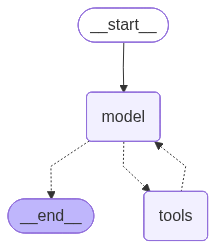

In [13]:
extended_helpdesk_agent = create_agent(
    model=llm,
    tools=extended_tools,
    system_prompt=EXTENDED_HELPDESK_PROMPT,
)
extended_helpdesk_agent

In [15]:
# Solution 3: Agent 실행
import nest_asyncio

nest_asyncio.apply()

response_ex1 = await extended_helpdesk_agent.ainvoke(
    {"messages": [HumanMessage(content="제 계정이 잠겼어요. user-bob-001입니다.")]}
)

final_answer_ex1 = response_ex1["messages"][-1].content
print(f"FINAL ANSWER 1:\n{final_answer_ex1}")

response_ex2 = await extended_helpdesk_agent.ainvoke(
    {
        "messages": [
            HumanMessage(content="최근에 제출한 티켓들을 확인하고 싶어요. user-alice-001입니다.")
        ]
    }
)

final_answer_ex2 = response_ex2["messages"][-1].content
final_answer_ex2

FINAL ANSWER 1:
안녕하세요! 

1. user-bob-001 계정이 잠겨 있어 확인한 결과, 로그인 실패로 잠긴 상태였습니다.
2. 계정을 해제해 드려 지금은 로그인 가능합니다.
3. 보안을 위해 비밀번호 변경을 권장합니다. 비밀번호 재설정을 도와드릴까요?


'안녕하세요! user-alice-001님의 최근 제출한 티켓 목록입니다:\n\n1. [TKT-2025-001] 비밀번호 초기화 요청 (상태: open)\n2. [TKT-2025-004] 계정 잠금 해제 (상태: resolved)\n\n다른 티켓 상태나 도움이 필요하시면 알려주세요!'

### LangGraph 는 Workflows를 구축하기 위해 역할하고, LangChain 은 Agent 를 만들기 위한 역할(V1.0 기준)

### LangGraph Workflow 구성 팁

1. **상태 설계**: 필요한 `최소 키`만 포함, 복잡한 객체보다 `단순 타입 선호`
2. **노드 책임**: 각 노드는 하나의 명확한 책임만 (Single Responsibility) => SOLID 원칙
3. **루프 방지**: 조건부 에지에서 반드시 종료 조건 명시 (예: 최대 반복 횟수, 품질 기준 충족)
4. **에러 핸들링**: 노드 내에서 예외 처리, 실패 시 상태에 에러 정보 기록


---

## Workflow 패턴 1: 프롬프트 체이닝 (Prompt Chaining)

### 개념
프롬프트 체이닝은 **여러 LLM 호출을 순차적으로 연결**하여 품질을 점진적으로 높이는 패턴입니다.

**핵심 특징**:
- 각 단계의 출력이 다음 단계의 입력이 됨
- 조건부 게이트(gate)로 품질 검증 후 조기 종료 또는 개선 단계 진입
- 명확한 품질 기준 설정 가능

**사용 사례**:
- 문서 작성: 초안 → 문법 교정 → 스타일 개선 → 최종 검토
- 번역: 직역 → 의역 → 문화적 뉘앙스 조정
- 코드 생성: 기본 로직 → 최적화 → 테스트 코드 추가


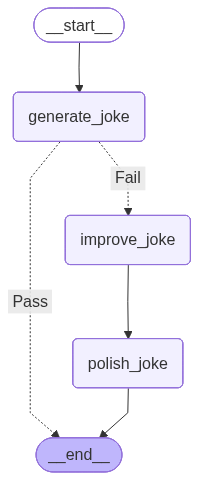

In [16]:
# 패턴 1: 프롬프트 체이닝 - 농담 생성 및 개선

from IPython.display import Image, display


# 1. 상태 정의
class JokeState(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# 2. 노드 함수들
def generate_joke(state: JokeState) -> dict:
    """초기 농담 생성"""
    topic = state["topic"]
    response = llm.invoke(f"{topic}에 대한 짧은 농담을 한국어로 작성해줘. 간결하게!")
    return {"joke": response.content}


def check_punchline(state: JokeState) -> str:
    """펀치라인 검증 게이트"""
    joke = state["joke"]
    # 간단한 휴리스틱: ?, ! 포함 여부로 펀치라인 존재 판단
    if "?" in joke or "!" in joke:
        return "Pass"
    return "Fail"


def improve_joke(state: JokeState) -> dict:
    """말장난 추가로 농담 개선"""
    joke = state["joke"]
    response = llm.invoke(f"다음 농담에 말장난(pun)을 추가해서 더 재미있게 만들어줘:\n\n{joke}")
    return {"improved_joke": response.content}


def polish_joke(state: JokeState) -> dict:
    """반전 추가로 최종 완성"""
    improved = state["improved_joke"]
    response = llm.invoke(f"다음 농담에 예상치 못한 반전(twist)을 추가해줘:\n\n{improved}")
    return {"final_joke": response.content}


# 3. 그래프 구축
joke_workflow = StateGraph(JokeState)

# 노드 추가
joke_workflow.add_node("generate_joke", generate_joke)
joke_workflow.add_node("improve_joke", improve_joke)
joke_workflow.add_node("polish_joke", polish_joke)

# 에지 연결
joke_workflow.add_edge(START, "generate_joke")

# 조건부 에지: 펀치라인 검증
joke_workflow.add_conditional_edges(
    "generate_joke",
    check_punchline,
    {
        "Pass": END,  # 펀치라인 있으면 바로 종료
        "Fail": "improve_joke",  # 없으면 개선 단계로
    },
)

joke_workflow.add_edge("improve_joke", "polish_joke")
joke_workflow.add_edge("polish_joke", END)

# 컴파일
joke_graph = joke_workflow.compile()
joke_graph


In [17]:
# 프롬프트 체이닝 실행 예제

import nest_asyncio

nest_asyncio.apply()

# 케이스 1: 펀치라인이 없는 주제 (개선 경로 진입)
result1 = await joke_graph.ainvoke({"topic": "프로그래머"})

print("=== 케이스 1: 프로그래머 농담 (개선 경로) ===")
print(f"초기 농담: {result1.get('joke', 'N/A')[:100]}...")
if "improved_joke" in result1:
    print(f"\n개선된 농담: {result1.get('improved_joke', 'N/A')[:100]}...")
    print(f"\n최종 농담:\n{result1.get('final_joke', 'N/A')}")
else:
    print("\n(펀치라인 검증 통과로 개선 단계 생략)")

print("\n" + "=" * 60 + "\n")

# 케이스 2: 다른 주제
result2 = await joke_graph.ainvoke({"topic": "고양이"})

print("=== 케이스 2: 고양이 농담 ===")
print(f"초기 농담: {result2.get('joke', 'N/A')}")
if "final_joke" in result2:
    print(f"\n최종 농담:\n{result2.get('final_joke', 'N/A')}")
else:
    print("\n(조기 종료됨)")


=== 케이스 1: 프로그래머 농담 (개선 경로) ===
초기 농담: 프로그래머 농담 하나요:

"코딩하다가 커피 마시면, 디버깅 대신 디카페인!"...

(펀치라인 검증 통과로 개선 단계 생략)


=== 케이스 2: 고양이 농담 ===
초기 농담: 고양이가 컴퓨터 앞에서 뭐라고 했을까요?  
"마우스 클릭이야!"

(조기 종료됨)


---

## Workflow 패턴 2: 병렬 실행 (Parallelization)

### 개념
병렬화는 **독립적인 하위 작업들을 동시에 실행**한 후, 결과를 집계(aggregate)하는 패턴입니다.

**핵심 특징**:
- 여러 노드가 같은 START 지점에서 시작 → LangGraph가 자동으로 병렬 실행
- 각 노드는 서로 독립적 (의존성 없음)
- 모든 병렬 노드 완료 후 집계 노드로 팬인(fan-in)

**사용 사례**:
- 다각도 분석: 같은 문서를 여러 관점에서 동시에 분석 (감정, 주제, 키워드)
- 다중 모델 앙상블: 여러 LLM에 동시 질의 후 결과 통합
- 대용량 배치: 데이터를 분할하여 병렬 처리

**성능 이점**:
- 총 실행 시간 = max(각 노드 시간) + 집계 시간 (순차 대비 N배 빠름)


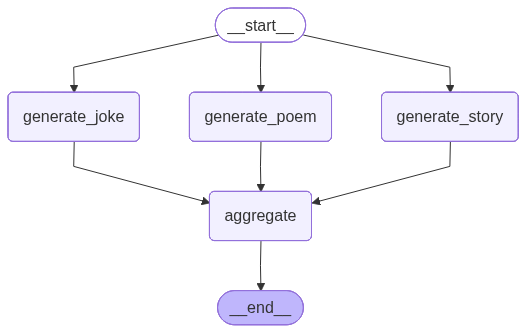

In [19]:
# 패턴 2: 병렬화 - 다중 콘텐츠 동시 생성

# 1. 상태 정의
class ParallelState(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined: str


# 2. 병렬 실행될 노드들 (각각 독립적)
def generate_joke_parallel(state: ParallelState) -> dict:
    """농담 생성"""
    topic = state["topic"]
    response = llm.invoke(f"{topic}에 대한 짧은 농담 (1-2문장)")
    return {"joke": response.content}


def generate_story(state: ParallelState) -> dict:
    """짧은 이야기 생성"""
    topic = state["topic"]
    response = llm.invoke(f"{topic}에 대한 짧은 이야기 (3-4문장)")
    return {"story": response.content}


def generate_poem(state: ParallelState) -> dict:
    """시 생성"""
    topic = state["topic"]
    response = llm.invoke(f"{topic}에 대한 4행시")
    return {"poem": response.content}


# 3. 집계 노드
def aggregate_results(state: ParallelState) -> dict:
    """모든 결과를 하나로 통합"""
    combined = f"""주제: {state["topic"]}

농담:
{state["joke"]}

이야기:
{state["story"]}

시:
{state["poem"]}
"""
    return {"combined": combined}


# 4. 그래프 구축
parallel_workflow = StateGraph(ParallelState)

# 병렬 노드 추가
parallel_workflow.add_node("generate_joke", generate_joke_parallel)
parallel_workflow.add_node("generate_story", generate_story)
parallel_workflow.add_node("generate_poem", generate_poem)
parallel_workflow.add_node("aggregate", aggregate_results)

# 병렬 에지: START에서 3개 노드로 동시 분기
parallel_workflow.add_edge(START, "generate_joke")
parallel_workflow.add_edge(START, "generate_story")
parallel_workflow.add_edge(START, "generate_poem")

# 팬인(fan-in): 3개 노드 모두 완료 후 aggregate로 수렴
parallel_workflow.add_edge("generate_joke", "aggregate")
parallel_workflow.add_edge("generate_story", "aggregate")
parallel_workflow.add_edge("generate_poem", "aggregate")

parallel_workflow.add_edge("aggregate", END)

# 컴파일
parallel_graph = parallel_workflow.compile()
parallel_graph


In [20]:
# 병렬 처리 실행 예제
result = parallel_graph.invoke({"topic": "우주여행"})

print(result["combined"])


주제: 우주여행

농담:
우주여행 갔다 왔더니 기분이 정말 ‘별’나! 지구로 돌아오니 중력이 반갑더라니까요! 🚀✨

이야기:
어느 날 나는 작은 우주선을 타고 별들 사이로 여행을 떠났다. 끝없이 펼쳐진 우주의 신비로움에 마음이 벅차올랐다. 지구의 파란 빛이 멀리서 반짝이며 나를 기다리고 있었다. 이 순간만큼은 우주와 내가 하나가 된 느낌이었다.

시:
우: 우주를 향한 우리의 꿈은  
주: 주저함 없이 끝없이 펼쳐져  
여: 여행하는 별들 사이에서  
행: 행복한 미래를 그려가리라



---

## Workflow 패턴 3: 라우팅 (Routing)

### 개념
라우팅은 **입력을 분류하여 서로 다른 처리 경로로 보내는** 패턴입니다.

**핵심 특징**:
- 라우터(분류기)가 입력 특성을 분석하여 적절한 노드 선택
- 각 경로는 특화된 처리 로직 수행
- 룰 기반 또는 LLM 기반 분류 가능

**사용 사례**:
- 고객 문의 분류: 기술지원 / 환불 / 제품문의 → 각 전담팀 라우팅
- 문서 타입 처리: PDF / HTML / Markdown → 각 파서로 전달
- 언어 감지: 한국어 / 영어 / 일본어 → 각 언어 모델로 처리
- 긴급도 분류: 긴급 / 일반 / 낮음 → 우선순위에 따른 처리

**라우터 구현 방법**:
1. **룰 기반**: 키워드, 정규식, 간단한 조건문
2. **LLM 분류**: Structured Output으로 카테고리 반환
3. **ML 모델**: 전통적인 분류 모델 (lightweight)


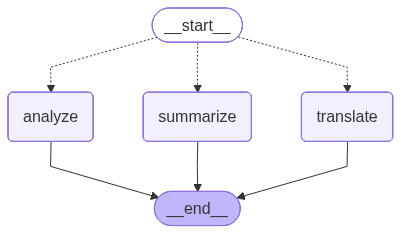

In [21]:
# 패턴 3: 라우팅 - 작업 분류

# 1. 상태 정의
class RoutingState(TypedDict):
    user_request: str
    result: str


# 2. 라우터 함수 (규칙 기반 분류)
def classify_request(state: RoutingState) -> Literal["summarize", "translate", "analyze"]:
    """사용자 요청을 분류하여 적절한 경로 선택"""
    request = state["user_request"].lower()

    # 간단한 키워드 매칭
    if "번역" in request or "translate" in request or "영어로" in request:
        return "translate"
    elif "요약" in request or "summary" in request or "짧게" in request:
        return "summarize"
    else:
        return "analyze"


# 3. 각 경로의 처리 노드들
def summarize_node(state: RoutingState) -> dict:
    """텍스트 요약"""
    request = state["user_request"]
    response = llm.invoke(f"다음 요청에서 핵심 내용을 3문장으로 요약해줘:\n\n{request}")
    return {"result": f"[요약 경로]\n{response.content}"}


def translate_node(state: RoutingState) -> dict:
    """영어로 번역"""
    request = state["user_request"]
    response = llm.invoke(f"다음 텍스트를 영어로 번역해줘:\n\n{request}")
    return {"result": f"[번역 경로]\n{response.content}"}


def analyze_node(state: RoutingState) -> dict:
    """일반 분석"""
    request = state["user_request"]
    response = llm.invoke(f"다음 요청을 분석하고 적절한 답변을 제공해줘:\n\n{request}")
    return {"result": f"[분석 경로]\n{response.content}"}


# 4. 그래프 구축
routing_workflow = StateGraph(RoutingState)

# 노드 추가
routing_workflow.add_node("summarize", summarize_node)
routing_workflow.add_node("translate", translate_node)
routing_workflow.add_node("analyze", analyze_node)

# 조건부 라우팅: START → classify_request → 분류된 노드
routing_workflow.add_conditional_edges(
    START,
    classify_request,
    {
        "summarize": "summarize",
        "translate": "translate",
        "analyze": "analyze",
    },
)

# 각 경로에서 END로
routing_workflow.add_edge("summarize", END)
routing_workflow.add_edge("translate", END)
routing_workflow.add_edge("analyze", END)

# 컴파일
routing_graph = routing_workflow.compile()
routing_graph

In [22]:
# 라우팅 실행 예제

# 테스트 케이스 1: 번역 경로
result1 = routing_graph.invoke(
    {
        "user_request": "LangGraph는 AI 워크플로우를 구축하는 프레임워크입니다. 이를 영어로 번역해주세요."
    }
)
print("=== 케이스 1: 번역 요청 ===")
print(result1["result"])

print("\n" + "=" * 60 + "\n")

# 테스트 케이스 2: 요약 경로
result2 = routing_graph.invoke(
    {
        "user_request": "인공지능은 현대 사회의 많은 분야에서 활용되고 있습니다. 의료, 금융, 교통, 제조업 등 다양한 산업에서 AI 기술이 도입되며 효율성과 정확성을 높이고 있습니다. 이를 짧게 요약해주세요."
    }
)
print("=== 케이스 2: 요약 요청 ===")
print(result2["result"])

print("\n" + "=" * 60 + "\n")

# 테스트 케이스 3: 분석 경로 (키워드 없음)
result3 = routing_graph.invoke({"user_request": "LangGraph와 LangChain의 차이점은 무엇인가요?"})
print("=== 케이스 3: 일반 질문 (분석 경로) ===")
print(result3["result"])

=== 케이스 1: 번역 요청 ===
[번역 경로]
LangGraph is a framework for building AI workflows.


=== 케이스 2: 요약 요청 ===
[요약 경로]
인공지능은 현대 사회 여러 분야에서 사용되고 있습니다. 의료, 금융, 교통, 제조업 등 다양한 산업에 AI가 도입되어 효율성과 정확성을 향상시키고 있습니다. AI는 산업 전반의 발전에 기여하고 있습니다.


=== 케이스 3: 일반 질문 (분석 경로) ===
[분석 경로]
LangGraph와 LangChain은 둘 다 자연어 처리 및 AI 애플리케이션 개발에 사용되는 도구들이지만, 목적과 기능 면에서 차이가 있습니다. 아래에 두 라이브러리의 주요 차이점을 정리했습니다.

### LangChain
- **주요 목적:** LLM(대형 언어 모델)을 중심으로 한 애플리케이션 개발을 돕는 프레임워크
- **주요 기능:...


---

## Workflow 패턴 4: 오케스트레이터-워커 (Orchestrator-Worker)

### 개념
오케스트레이터-워커는 **복잡한 작업을 하위 작업으로 분해하고, 각 워커가 순차/반복 처리한 뒤, 결과를 통합**하는 패턴입니다.

**핵심 특징**:
- **오케스트레이터**: 작업 분해 및 계획 수립
- **워커**: 하위 작업을 하나씩 처리 (루프 구조)
- **합성기(Synthesizer)**: 모든 워커 결과를 최종 통합

**사용 사례**:
- 리포트 작성: 배경조사 → 데이터 분석 → 결론 도출 → 최종 편집
- 멀티스텝 리서치: 주제 분해 → 각 주제별 검색 → 통합 리포트
- 파이프라인 작업: 데이터 청소 → 변환 → 검증 → 저장

**병렬 처리와의 차이**:
- 병렬 처리: 모든 작업이 **동시** 실행 (독립적)
- 오케스트레이터-워커: 작업이 **순차** 실행되며, 각 작업은 이전 컨텍스트 활용 가능

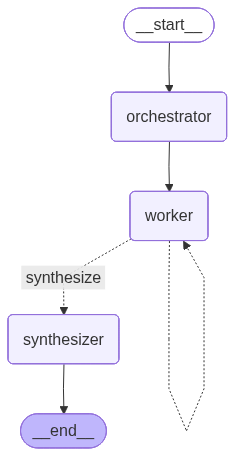

In [24]:
# 패턴 4: 오케스트레이터-워커 - 리포트 작성

# 1. 상태 정의
class OrchestratorState(TypedDict):
    topic: str
    tasks: list[str]
    drafts: list[str]
    final_report: str


# 2. 오케스트레이터 노드
def orchestrator(state: OrchestratorState) -> dict:
    """작업을 하위 태스크로 분해"""
    topic = state["topic"]

    # 리포트 작성을 3개 섹션으로 분해
    tasks = [
        f"{topic}의 배경과 역사",
        f"{topic}의 핵심 개념 3가지",
        f"{topic}의 실전 활용 사례",
    ]

    return {"tasks": tasks, "drafts": []}


# 3. 워커 노드 (반복 실행)
def worker(state: OrchestratorState) -> dict:
    """다음 태스크를 처리"""
    tasks = state["tasks"]
    drafts = state.get("drafts", [])

    # 현재 처리할 태스크 인덱스
    current_idx = len(drafts)

    if current_idx < len(tasks):
        current_task = tasks[current_idx]

        # LLM으로 현재 태스크 수행
        response = llm.invoke(f"다음 주제에 대해 2-3문장으로 설명해줘:\n\n{current_task}")

        # 결과를 drafts에 추가
        new_drafts = drafts + [f"### {current_task}\n{response.content}"]
        return {"drafts": new_drafts}

    return {}


# 4. 조건부 라우팅: 모든 태스크 완료 확인
def check_completion(state: OrchestratorState) -> str:
    """모든 태스크가 완료되었는지 확인"""
    tasks = state["tasks"]
    drafts = state.get("drafts", [])

    if len(drafts) >= len(tasks):
        return "synthesize"  # 모두 완료 → 합성 단계로
    else:
        return "worker"  # 아직 남음 → 워커 재실행


# 5. 합성기 노드
def synthesizer(state: OrchestratorState) -> dict:
    """모든 섹션을 하나의 리포트로 통합"""
    topic = state["topic"]
    drafts = state["drafts"]

    final_report = f"""# {topic} 리포트

{chr(10).join(drafts)}

---
*생성일: LangGraph 오케스트레이터-워커 패턴*
"""
    return {"final_report": final_report}


# 6. 그래프 구축
ow_workflow = StateGraph(OrchestratorState)

# 노드 추가
ow_workflow.add_node("orchestrator", orchestrator)
ow_workflow.add_node("worker", worker)
ow_workflow.add_node("synthesizer", synthesizer)

# 에지 연결
ow_workflow.add_edge(START, "orchestrator")
ow_workflow.add_edge("orchestrator", "worker")

# 조건부 에지: 워커가 완료되면 synthesizer로, 아니면 워커 재실행
ow_workflow.add_conditional_edges(
    "worker",
    check_completion,
    {
        "worker": "worker",  # 루프: 다음 태스크 처리
        "synthesize": "synthesizer",  # 완료: 합성 단계로
    },
)

ow_workflow.add_edge("synthesizer", END)

# 컴파일
ow_graph = ow_workflow.compile()
ow_graph

In [25]:
# 오케스트레이터-워커 실행 예제

result = ow_graph.invoke({"topic": "LangGraph"})

print("=== 최종 리포트 ===\n")
print(result["final_report"])

print("\n" + "=" * 60)
print(f"\n처리된 태스크 수: {len(result['tasks'])}")
print(f"생성된 섹션 수: {len(result['drafts'])}")

=== 최종 리포트 ===

# LangGraph 리포트

### LangGraph의 배경과 역사
LangGraph는 인공지능과 자연어 처리 기술의 발전에 발맞춰 복잡한 언어 데이터를 시각적으로 표현하고 분석하기 위해 개발된 그래프 기반 도구입니다. 초기 연구는 언어 구조의 이해와 의미 관계를 명확히 하기 위해 시작되었으며, 이후 다양한 AI 응용 분야에서 활용되며 그 가치를 입증해왔습니다.
### LangGraph의 핵심 개념 3가지
LangGraph의 핵심 개념 3가지는 노드(Node), 엣지(Edge), 그리고 그래프 구조(Graph Structure)입니다. 노드는 개별 데이터나 개체를 나타내며, 엣지는 이들 노드 간의 관계를 표현합니다. 그래프 구조를 통해 복잡한 정보와 연관성을 시각적이고 체계적으로 분석할 수 있습니다.
### LangGraph의 실전 활용 사례
LangGraph는 복잡한 데이터와 지식을 시각적으로 연결해 이해를 돕는 도구로, 기업의 고객 데이터 분석 및 의사결정 지원에 활용되고 있습니다. 예를 들어, 마케팅 전략 수립 시 다양한 고객 행동 패턴과 연관 데이터를 그래프로 표현해 인사이트를 빠르게 도출할 수 있습니다. 또한, 연구 개발 분야에서는 다양한 연구 결과와 논문 데이터를 연결해 새로운 아이디어 발굴에 도움을 줍니다.

---
*생성일: LangGraph 오케스트레이터-워커 패턴*



처리된 태스크 수: 3
생성된 섹션 수: 3


---

## Workflow 패턴 5: 평가자-최적화 (Evaluator-Optimizer Loop)

### 개념
평가자-최적화는 **생성 → 평가 → 개선을 반복**하여 품질 기준을 충족할 때까지 결과를 개선하는 패턴입니다.

**핵심 특징**:
- **생성기(Generator)**: 초안 또는 개선안 생성
- **평가자(Evaluator)**: 품질 기준에 따라 평가 (Structured Output 활용)
- **피드백 루프**: 평가 결과를 생성기에 전달하여 재생성
- **종료 조건**: 품질 기준 충족 OR 최대 반복 횟수 도달

**사용 사례**:
- 코드 생성: 생성 → 테스트 → 버그 수정 반복
- 문서 작성: 초안 → 품질 검증 → 개선 반복
- 데이터 검증: 생성 → 검증 → 수정 반복
- 번역 품질 향상: 번역 → 평가 → 재번역

**프롬프트 체이닝과의 차이**:
- 프롬프트 체이닝: 고정된 단계 (A → B → C)
- 평가자-최적화: 동적 반복 (Generate → Evaluate → 기준 미달 시 Regenerate)

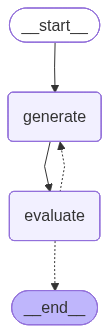

In [26]:
# 패턴 5: 평가자-최적화 루프 - 문서 작성

# 1. 평가 결과를 위한 Pydantic 모델
class DocumentFeedback(BaseModel):
    grade: Literal["excellent", "good", "needs_improvement"] = Field(description="문서 품질 등급")
    feedback: str = Field(description="구체적인 개선 사항")


# 2. 상태 정의
class EvalOptimizerState(TypedDict):
    topic: str
    draft: str
    grade: str
    feedback: str
    iteration: int
    max_iterations: int


# 3. 생성기 노드
def generate_document(state: EvalOptimizerState) -> dict:
    """문서 생성 또는 재생성"""
    topic = state["topic"]
    feedback = state.get("feedback", "")
    iteration = state.get("iteration", 0)

    if iteration == 0:
        # 초안 생성
        prompt = f"{topic}에 대한 기술 문서를 작성해줘. 명확하고 구조적으로 3-4문장."
    else:
        # 피드백 반영하여 재생성
        draft = state["draft"]
        prompt = f"""다음 문서를 개선해줘.

현재 문서:
{draft}

피드백:
{feedback}

개선된 문서를 작성해줘."""

    response = llm.invoke(prompt)
    return {"draft": response.content, "iteration": iteration + 1}


# 4. 평가자 노드 (Structured Output)
evaluator_llm = llm.with_structured_output(DocumentFeedback)


def evaluate_document(state: EvalOptimizerState) -> dict:
    """문서 품질 평가"""
    draft = state["draft"]

    evaluation_prompt = f"""다음 기술 문서를 평가해줘:

{draft}

평가 기준:
- 명확성: 이해하기 쉬운가?
- 구조: 논리적인 흐름인가?
- 완성도: 충분한 설명인가?

등급:
- excellent: 모든 기준 충족
- good: 대체로 양호하나 소폭 개선 가능
- needs_improvement: 명확한 개선 필요"""

    feedback = evaluator_llm.invoke(evaluation_prompt)

    return {"grade": feedback.grade, "feedback": feedback.feedback}


# 5. 조건부 라우팅: 계속 개선 vs 종료
def should_continue(state: EvalOptimizerState) -> str:
    """종료 조건 확인"""
    grade = state.get("grade", "")
    iteration = state.get("iteration", 0)
    max_iter = state.get("max_iterations", 3)

    # 종료 조건
    if grade == "excellent":
        return END  # 품질 기준 충족
    elif iteration >= max_iter:
        return END  # 최대 반복 도달
    else:
        return "generate"  # 재생성


# 6. 그래프 구축
eval_optimizer_workflow = StateGraph(EvalOptimizerState)

# 노드 추가
eval_optimizer_workflow.add_node("generate", generate_document)
eval_optimizer_workflow.add_node("evaluate", evaluate_document)

# 에지 연결
eval_optimizer_workflow.add_edge(START, "generate")
eval_optimizer_workflow.add_edge("generate", "evaluate")

# 조건부 루프
eval_optimizer_workflow.add_conditional_edges(
    "evaluate",
    should_continue,
    {
        "generate": "generate",  # 개선 필요 → 재생성
        END: END,  # 종료 조건 충족
    },
)

# 컴파일
eval_optimizer_graph = eval_optimizer_workflow.compile()
eval_optimizer_graph

In [27]:
# 평가자-최적화 실행 예제

result = eval_optimizer_graph.invoke({"topic": "LangGraph 워크플로우 패턴", "max_iterations": 3})
result

{'topic': 'LangGraph 워크플로우 패턴',
 'draft': 'LangGraph 워크플로우 패턴은 복잡한 작업을 단계별로 체계화하여 효율적으로 처리할 수 있도록 설계된 구조적 워크플로우 모델입니다. 각 단계는 명확한 입력과 출력을 정의하며, 이들 단계 간의 데이터 및 제어 흐름은 그래프 형태로 시각화되어 가독성과 유지보수성을 크게 향상시킵니다. 이러한 구성은 반복 가능하고 확장성 있는 자동화 프로세스 구현을 가능하게 합니다.\n\n특히, LangGraph는 다양한 모듈화된 컴포넌트의 결합을 통해 여러 워크플로우 시나리오에 유연하게 적용할 수 있습니다. 예를 들어, 데이터 수집→전처리→분석→결과 보고의 각 처리를 독립적인 노드로 나누고, 이들이 방향성 그래프로 연결되어 단계별 흐름을 명확히 보여줍니다. 이를 통해 개발자는 특정 단계만 수정하거나 추가하는 식으로 전체 워크플로우를 쉽게 확장하고 조정할 수 있습니다.\n\n아래는 LangGraph 워크플로우 패턴의 예시 구조도입니다.\n\n```\n[데이터 수집] → [데이터 전처리] → [데이터 분석] → [보고서 생성]\n```\n\n각 노드는 입력 데이터와 출력 데이터를 명확히 지정하며, 필요한 경우 조건 분기나 반복 처리도 그래프 내에서 표현 가능합니다. 이러한 시각적·구조적 접근은 복잡한 자동화 작업의 이해도를 높이고 유지 관리의 효율성을 극대화합니다.\n\n따라서 LangGraph 워크플로우 패턴은 체계적이고 확장 가능한 자동화 설계를 위한 강력한 도구로서, 다양한 산업 분야의 복잡한 프로세스 최적화에 적합합니다.',
 'grade': 'excellent',
 'feedback': '이 기술 문서는 LangGraph 워크플로우 패턴의 개념과 특성을 명확하고 체계적으로 설명하고 있습니다. 각 단계별 흐름과 그래프 기반 시각화의 이점을 구체적인 예시와 함께 제시하여 이해를 돕고 있으며, 자동화 프로세스 확장성과 유지보수 용이성에 대해서도 충분히 다루고 있습니다. 논리적인 흐름과 완성도가 높아 독